# Goal: Define task events & associated locations & costs

In [1]:
import os 
from pathlib import Path
CURRENT_DIR = Path(os.getcwd())
EXAMPLE_DIR = CURRENT_DIR.parent
HOME_DIR = EXAMPLE_DIR.parent

# os.chdir(os.path.join('../..'))
os.chdir(HOME_DIR)

In [2]:
%load_ext autoreload
%autoreload 2

# additional imports
import re
import numpy as np
import pandas as pd
import networkx as nx
from IPython.display import Video
import matplotlib.colors as mcolors
from tpossp import utils # TODO: COPY-PASTED from TPO. MUST DELETE OR MERGE INTO TPOSSP

CURRENT_DATA_DIR = os.path.join(CURRENT_DIR, 'data')
CURRENT_OUTPUT_DIR = os.path.join(CURRENT_DIR, 'output')
CURRENT_CONFIG_FILENAME = os.path.join(CURRENT_DIR, 'config.json')

# 1.Got the experiment idea from a paper 

Title: "Causal analysis of aircraft turnaround time for process reliability evaluation and disruptions’ identification"
Paper: https://www.tandfonline.com/doi/full/10.1080/21680566.2017.1325784

Table 2 (Renamed to `ground_services_by_operations.csv`): https://www.tandfonline.com/action/downloadTable?id=T0002&doi=10.1080%2F21680566.2017.1325784&downloadType=CSV
Table 3 (Renamed to `duration.csv`): https://www.tandfonline.com/action/downloadTable?id=T0003&doi=10.1080%2F21680566.2017.1325784&downloadType=CSV

# Load CSV Files

In [3]:
filename = os.path.join(CURRENT_DATA_DIR, 'my_experiment_setup.csv')
df = pd.read_csv(filename)
df

,No.,Activity,ServiceTime,Service,From,To,Precedence,Operation
0,1,Arrival,0,Uncontrollable,NaN,NaN,,Start Deboarding
1,2,PlaceStairs,0,Move,StairsStation,StairsLoc,1,Start Deboarding
2,3,Deboarding,25,Uncontrollable,StairsLoc,StairsLoc,2,Deboarding
3,4,PlaceCateringVehicle,0,Move,CateringStation,CateringLoc,1,Catering
4,5,StartCatering,10,Stay,CateringLoc,CateringLoc,"3,4",Catering
5,6,MoveOutCateringVehicle,0,Move,CateringLoc,CateringStation,5,Catering
6,7,PlaceAndStartRefueling,0,Move,RefuelingStation,RefuelingLoc,1,Refueling
7,8,Refueling,15,Uncontrollable,RefuelingLoc,RefuelingLoc,7,Refueling
8,9,EndAndMoveOutRefueling,0,Move,RefuelingLoc,RefuelingStation,8,Refueling
9,10,PlaceConveyerVehicle,0,Move,ConveyerStation,ConveyerLoc,1,Bulk Unloading


In [4]:
def graph_from_df(df, 
                  num_str: str='No.', 
                  op_str: str='Operation', 
                  act_str: str='Activity', 
                  prec_str: str='Precedence'):

    # Select a color for an operation
    operations = df[op_str].unique()
    colors = list(mcolors.CSS4_COLORS.keys())

    # Select colros at equidistant
    indices = np.round(np.linspace(0, len(mcolors.CSS4_COLORS) - 1, len(operations))).astype(int)
    selected_colors = {operations[i]: colors[idx] for i, idx in enumerate(indices)}

    g = nx.DiGraph()

    for _, row in df.iterrows():
        # Add Nodes
        curr = row[num_str]
        act = row[act_str]
        op = row[op_str]
        color = selected_colors[op]
        g.add_node(curr, Activity=act, Operation=op, fillcolor=color, style='filled')

        # Add Edges 
        precs = row.get(prec_str)
        if precs is not None:
            values = re.findall(r'\d+', precs)
            if len(values) != 0:
                for value in values:
                    value = int(value)
                    g.add_edge(value, curr)

    return g

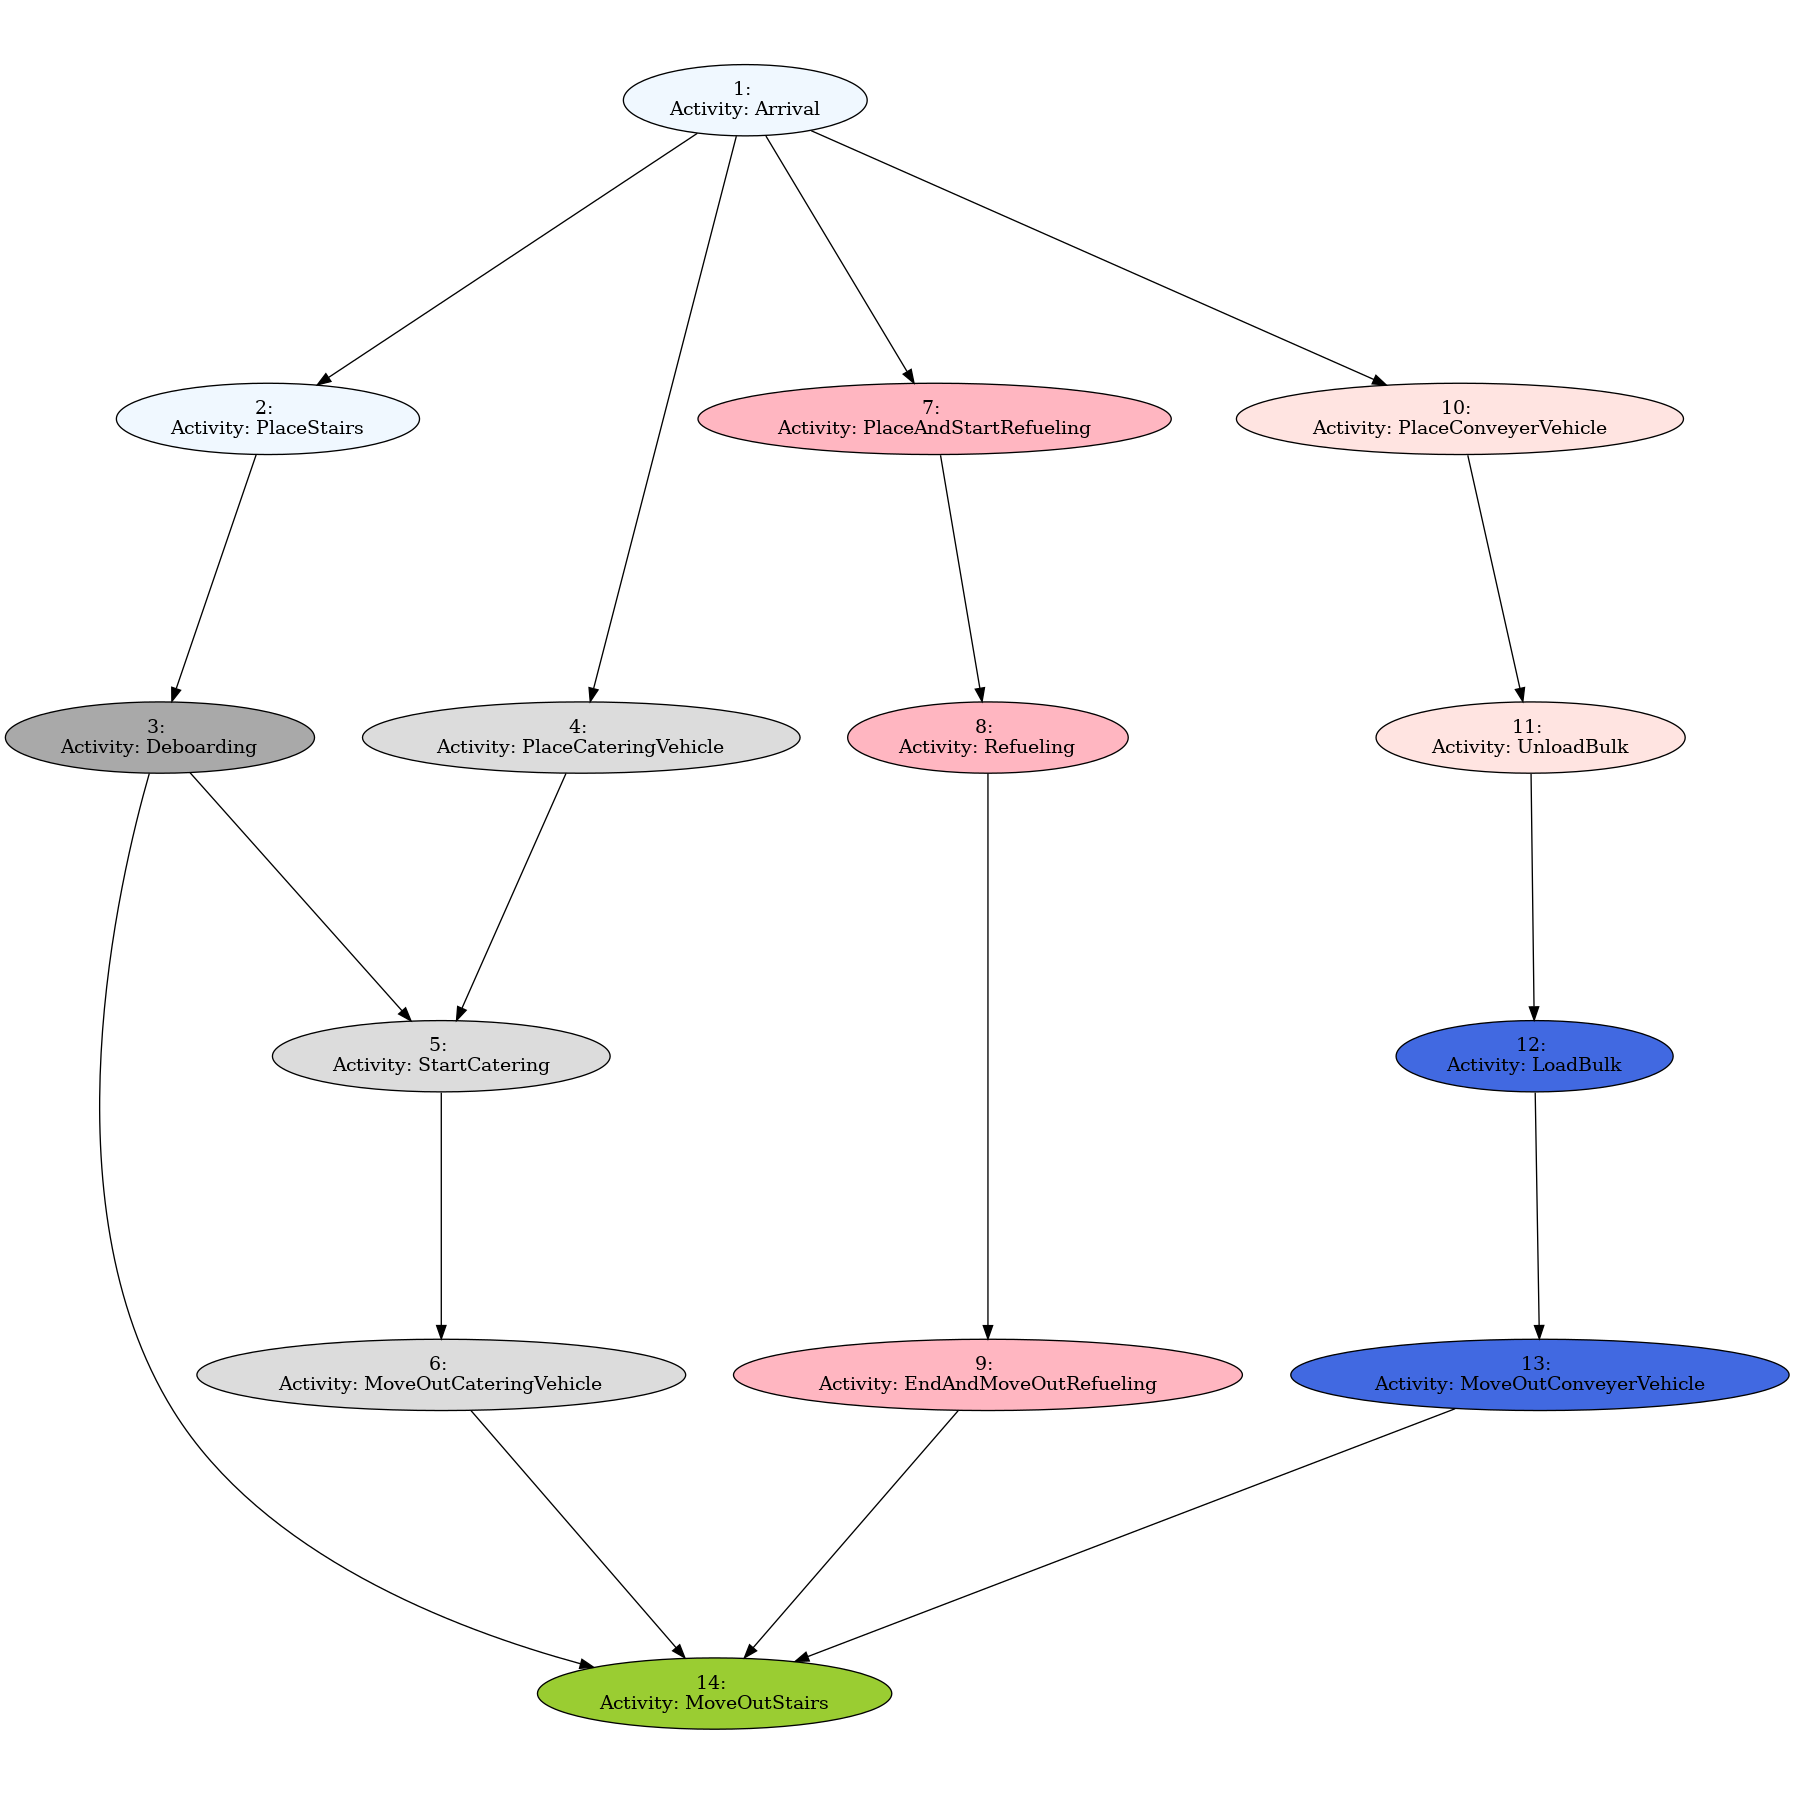

In [5]:
g = graph_from_df(df)
node_label_function = lambda n, data: utils.node_label_function(n, data, ['Activity'])
edge_label_function = lambda u, v, data: ''
utils.add_labels(g, node_label_function, edge_label_function)
utils.draw(g, os.path.join(CURRENT_OUTPUT_DIR, 'original_graph'), True)

In [6]:
import gym
from tpossp.minigrid import EightDirectionActionWrapper
from wombats.automaton import active_automata
from wombats.systems import StaticMinigridTSWrapper
from tpossp.tsconverter import TSConverter, AircraftTurnaroundTSToTSPConverter

# ENV_ID = 'MiniGrid-AircraftTurnaroundEnv-v0'
# env = gym.make(ENV_ID)
# env = EightDirectionActionWrapper(env)
# env = StaticMinigridTSWrapper(env)
# minigrid_TS = active_automata.get(automaton_type='TS', graph_data=env,
#                                   graph_data_format='minigrid')
# env.reset()
# env.render_notebook()

ENV_ID = 'MiniGrid-AspenAircraftTurnaroundEnv-v0'
env = gym.make(ENV_ID)
env = EightDirectionActionWrapper(env)
env = StaticMinigridTSWrapper(env)

/home/kandai/Documents/projects/dev/tpossp/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
minigrid_TS = active_automata.get(automaton_type='TS', graph_data=env,
                                  graph_data_format='minigrid')
# EXPERIMENT_NAME = 'TEST'
# minigrid_TS.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'TS']))

In [ ]:
env.reset()
env.render_notebook()

for label, locations in env.cell_obs_map.items():
    print(label, locations)
position_labels = set(df['From'].to_list() + df['To'].to_list())
print("Position Labels: ", position_labels)

# Now MANUALLY map the Position Labels to Positions (x, y)

Locations and Stations are represented as Boxes and Floors respectively. 
Purple == Catering 
Red == Stairs
Green == Conveyer
Blue == Refueling

In [ ]:
from tpossp.tsconverter import Service
from bidict import bidict
initial_locations = [(2, 2),(2, 18),(10, 10)]
initial_locations = [(10, 10)]
# position_label_to_location = bidict({
#     'CateringLoc': (7, 12),
#     'CateringStation': (10, 19),
#     'StairsLoc': (5, 7),
#     'StairsStation': (1, 7),
#     'ConveyerLoc': (7, 8),
#     'ConveyerStation': (11, 8),
#     'RefuelingLoc': (8, 9),
#     'RefuelingStation': (11, 9),
# })
position_label_to_location = bidict({
    'CateringLoc': (5, 13),
    'CateringStation': (1, 20),
    'StairsLoc': (5, 7),
    'StairsStation': (1, 7),
    'ConveyerLoc': (7, 13),
    'ConveyerStation': (11, 13),
    'RefuelingLoc': (7, 7),
    'RefuelingStation': (11, 7),
})
services = []
for index, row in df.iterrows():
    name = row['Activity']
    type = row['Service']
    from_str = row['From']
    to_str = row['To']
    service_time = row['ServiceTime']
    if not isinstance(from_str, str):
        from_str = ""
    if not isinstance(to_str, str):
        to_str = ""
    controllable = type != "Uncontrollable"
    precedences = [g.nodes[n]['Activity'] for n in g.predecessors(row['No.'])]
    print(f"Precedent to {name}: {precedences}")
    services.append(Service(name, type, from_str, to_str, service_time, controllable, precedences))

In [ ]:
ts_converter = AircraftTurnaroundTSToTSPConverter(
    minigrid_TS, 
    initial_locations, 
    services,
    position_label_to_location,
    ignoring_obs_keys=["empty", "lava"])
nodes, costs, service_times = ts_converter.to_tsp_nodes_and_costs()

service_names = [ts_converter.service_to_node.inverse[node].name for node in nodes]

print("-"*100)
print('Visiting the nodes: ', nodes)
print('Visiting the services: ', service_names)
print("-"*100)
print("[Service]: [From] -> [To]=[ServiceTime]")

for node in nodes:
    service = ts_converter.service_to_node.inverse[node]
    if service in ts_converter.uncontrollables:
        print(service.name, "Uncontrollable")
        continue
    from_state = ts_converter.service_position_label_to_state(service.from_str)
    to_state = ts_converter.service_position_label_to_state(service.to_str)
    node = ts_converter.service_to_node[service]
    service_time = service_times[node]
    print(f"{service.name}: {from_state}->{to_state}={service_time}")

print(costs)
print("We assume that there are no redenduant services")

In [ ]:
def construct_tpo_constraints(g, ts_converter): 
    local_constraints = {}
    for src, d in g.nodes(data=True):
        src_service_name = d['Activity']
        src_node = ts_converter.service_name_to_node[src_service_name]
        for tgt in g.successors(src):
            tgt_service_name = g.nodes[tgt]['Activity']
            tgt_node = ts_converter.service_name_to_node[tgt_service_name]
            service = ts_converter.name_to_service[tgt_service_name]
            lb = 0
            if service.service_time > 0:
                lb = service.service_time
            local_constraints[(src_node, tgt_node)] = (lb, float('inf'))
    return local_constraints

local_constraints = construct_tpo_constraints(g, ts_converter)
for (srcn, tgtn), (lb, ub) in local_constraints.items():
    sn = ts_converter.service_to_node.inverse[srcn].name
    tn = ts_converter.service_to_node.inverse[tgtn].name
    print(sn, tn, lb, ub)

In [ ]:
from tpossp.solver.milp import MILPTSPTCSolverWithUncontrollable
from tpossp.tpo import TPO
from tpossp.tsptc import TSPTC

global_constraints = {}
tpo = TPO(global_constraints, local_constraints)
tsptc = TSPTC(nodes, costs, tpo, service_times)

uncontrollable_nodes = [ts_converter.service_to_node[s] for s in ts_converter.uncontrollables]
init_nodes = [n for n in nodes if "Robot" in ts_converter.service_to_node.inverse[n].name]
uncontrollable_init_nodes = [ts_converter.service_to_node[s] for s in ts_converter.uncontrollables if s.name == "Arrival"]
init_nodes.append(uncontrollable_init_nodes[0])
print(init_nodes)
print([ts_converter.service_to_node.inverse[n].name for n in init_nodes])

solver = MILPTSPTCSolverWithUncontrollable(tsptc, uncontrollable_nodes, init_nodes=init_nodes)

tours, cost, times = solver.solve()
print(tours, cost, times)

In [ ]:
for tour in tours:
    print("-"*20 + "New Tour" + "-"*20)
    for n in tour:
        service = ts_converter.service_to_node.inverse[n]
        print(f"Service={service.name}: Start={times['start'][n]}, End={times['end'][n]}")

In [ ]:
# Now, given a tour, times, and a converter, come up with a waypoints w/ timeouts

tour_ = tours[0]
# Compute the control inputs
controls, trace = ts_converter.to_controls(tour_, times)
print('Controls: ', len(controls), controls,)
print('Trace', len(trace), trace)
# Set the Initial State
s = ts_converter.service_to_node.inverse[tour_[0]]
minigrid_TS.start_state = ts_converter.service_position_label_to_state(s.from_str)
# Simulate
output_string, visited_states, video_path = minigrid_TS.run(controls,
                                                            record_video=True)
locations = [ts_converter.state_to_location(s) for s in visited_states]
# Print out
services = [ts_converter.service_to_node.inverse[n] for n in tour_]
service_names = [s.name for s in services]
print('Tour: ', tour_)
print('Services: ', service_names)
print('Visited States: ', visited_states)
print('Locations: ', locations)
print("Saved to ", video_path)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")


In [ ]:

tour_ = tours[2]
# Compute the control inputs
controls, trace = ts_converter.to_controls(tour_, times)
print('Controls: ', len(controls), controls,)
print('Trace', len(trace), trace)
# Set the Initial State
s = ts_converter.service_to_node.inverse[tour_[0]]
minigrid_TS.start_state = ts_converter.service_position_label_to_state(s.from_str)
# Simulate
output_string, visited_states, video_path = minigrid_TS.run(controls,
                                                            record_video=True)
locations = [ts_converter.state_to_location(s) for s in visited_states]
# Print out
services = [ts_converter.service_to_node.inverse[n] for n in tour_]
service_names = [s.name for s in services]
print('Tour: ', tour_)
print('Services: ', service_names)
print('Visited States: ', visited_states)
print('Locations: ', locations)
print("Saved to ", video_path)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")


In [ ]:

tour_ = tours[3]
# Compute the control inputs
controls, trace = ts_converter.to_controls(tour_, times)
print('Controls: ', len(controls), controls,)
print('Trace', len(trace), trace)
# Set the Initial State
s = ts_converter.service_to_node.inverse[tour_[0]]
minigrid_TS.start_state = ts_converter.service_position_label_to_state(s.from_str)
# Simulate
output_string, visited_states, video_path = minigrid_TS.run(controls,
                                                            record_video=True)
locations = [ts_converter.state_to_location(s) for s in visited_states]
# Print out
services = [ts_converter.service_to_node.inverse[n] for n in tour_]
service_names = [s.name for s in services]
print('Tour: ', tour_)
print('Services: ', service_names)
print('Visited States: ', visited_states)
print('Locations: ', locations)
print("Saved to ", video_path)
Video(video_path, embed=True, html_attributes="controls muted autoplay loop")


# Physical Experiment
- We need waypoints with timeout (end of service time)

In [ ]:
import csv
import numpy as np

class AspenLabExperimentHelper:
    def __init__(self, tsconverter, 
                 vx=0.01, vy=0.01, posTol=0.1, XMAX=11, YMAX=21, 
                 meter_per_xgrid=0.5, meter_per_ygrid=0.60):
        self.tsconverter = tsconverter
        self.vx = vx
        self.vy = vy
        self.posTol = posTol
        self.XMAX = XMAX
        self.YMAX = YMAX
        self.meter_per_xgrid = meter_per_xgrid
        self.meter_per_ygrid = meter_per_ygrid

    def locations_to_pivots(self, locations):
        """Convert every grid waypoints to waypoints such that 
        waypoint exists only when the robot's direction changes.
        This helps us reduce the zigzag motion of the robot 
        (in real-life experiment).

        Args:
            locations (List[Tuple[int, int)]): 
        """
        if len(locations) == 0: return []
        prev_loc = locations[0]
        prev_diff = None
        pivots = []
        for curr_loc in locations:
            curr_diff = np.array([l2-l1 for l1, l2 in zip(prev_loc, curr_loc)])
            # Skip if same location
            if prev_loc == curr_loc: 
                prev_loc = curr_loc
                prev_diff = curr_diff
                continue
            # Skip if same direction 
            if prev_diff is not None:
                if (curr_diff == prev_diff).all():
                    prev_loc = curr_loc
                    prev_diff = curr_diff
                    continue
            pivots.append(prev_loc)
            prev_loc = curr_loc
            prev_diff = curr_diff
        return pivots

    def locations_to_timedpivots(self, locations, timed_trace):
        """Convert every grid waypoints to waypoints such that 
        waypoint exists only when the robot's direction changes.
        This helps us reduce the zigzag motion of the robot 
        (in real-life experiment).

        Args:
            locations (List[Tuple[int, int)]): 
        """
        assert len(locations) == len(timed_trace)
        if len(locations) == 0: return []
        prev_loc = locations[0]
        prev_t = timed_trace[0][0]
        prev_diff = None
        timedpivots = []
        for curr_loc, (curr_t, n) in zip(locations, timed_trace):
            curr_diff = np.array([l2-l1 for l1, l2 in zip(prev_loc, curr_loc)])

            if prev_t <= 0:
                # Skip if same location
                if prev_loc == curr_loc: 
                    prev_loc = curr_loc
                    prev_diff = curr_diff
                    prev_t = curr_t
                    continue

                # Skip if same direction 
                if prev_diff is not None:
                    if (curr_diff == prev_diff).all():
                        prev_loc = curr_loc
                        prev_diff = curr_diff
                        prev_t = curr_t
                        continue

            timedpivots.append((*prev_loc, prev_t))
            prev_loc = curr_loc
            prev_diff = curr_diff
            prev_t = curr_t
        
        timedpivots.append((*locations[-1], 0))
        return timedpivots

    def transform_coordinates(self, x, y):
        # Ensure that the input coordinates are within the valid range
        assert 1 <= x <= self.XMAX and 1 <= y <= self.YMAX
        # Invert the y-coordinate by subtracting it from the maximum value in the range
        y_prime = self.YMAX+1 - y

        # BEFORE DEADLINE MODE!!!
        # Return the transformed coordinates
        x_aspen =self.meter_per_xgrid*(x-1)
        y_aspen = self.meter_per_ygrid*(y_prime-1 - 1)
        if x_aspen == [3.0, 3.5, 4.0]:
            x_aspen += 0.2
        elif x_aspen in [2.5, 2.0]:
            x_aspen -= 0.2
        elif x_aspen == 5.0:
            x_aspen = 5.2
        elif x_aspen == 0.0:
            x_aspen = -0.1
        return x_aspen, y_aspen

    def write_to_csv(self, timedpivots, filepath):
        writer = csv.writer(open(filepath, 'w'), delimiter=' ')
        for i, (x, y, t) in enumerate(timedpivots):
            # Let's just use the last element for timeTol ...
            row = [i, x, self.vx, y, self.vy, self.posTol, t]
            writer.writerow(row)

In [ ]:

RETURN_STATES_AS_WAYPOINTS = True
helper = AspenLabExperimentHelper(ts_converter)

# Now, given a tour, times, and a converter, come up with a waypoints w/ timeouts
for tour_ in tours:

    # Compute the control inputs
    controls, trace = ts_converter.to_controls(tour_, times, RETURN_STATES_AS_WAYPOINTS)
    if len(controls) == 0: continue

    timed_trace = []
    for n in trace:
        timedstamp = 0
        if n != -1:
            timedstamp = times['start'][n]
        timed_trace.append((timedstamp, n))
    print('Timed Trace', timed_trace)

    # Set the initial state
    s = ts_converter.service_to_node.inverse[tour_[0]]
    minigrid_TS.start_state = ts_converter.service_position_label_to_state(s.from_str)
    # Simulate
    _, visited_states, _ = minigrid_TS.run(controls, record_video=False)
    locations = [ts_converter.state_to_location(s) for s in visited_states]

    services = ts_converter.tour_to_services(tour_)
    service_names = [s.name for s in services]
    timedpivots = helper.locations_to_timedpivots(locations, timed_trace)
    aspentimedpivots = [(*helper.transform_coordinates(x,y),t) for (x,y,t) in timedpivots] 

    print('Tour: ', tour_)
    print('Services: ', service_names)
    print('Pivots', timedpivots)
    print('Aspen', aspentimedpivots)

    filepath = os.path.join(CURRENT_OUTPUT_DIR, service_names[0]+'.csv')
    print(f"Saving to ... {filepath}")
    helper.write_to_csv(aspentimedpivots, filepath) 

# TODO

- Only Record a state when the direction changes.
- Test waiting time at a specific location.
- Find a good tour such that they don't intersect much
  
- Write a function that outputs a csv. 
  - If service time must be spent at that point, create a duplicate goal location x,y with service (timeout) time. 


If that's possible, then we are mostly done!
